# Assignment 3 : Multi-label Image Classification

In [1]:
# %%sh
# chmod 777 download_data.sh
# ./download_data.sh
# watch -d -n 0.5 nvidia-smi

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import transforms
from sklearn.metrics import average_precision_score
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from kaggle_submission import output_submission_csv
from classifier import Classifier
from voc_dataloader import VocDataset, VOC_CLASSES

%matplotlib inline
%load_ext autoreload
%autoreload 2

In this assignment, you train a classifier to do multi-label classificaton on the PASCAL VOC 2007 dataset. The dataset has 20 different class which can appear in any given image. Your classifier will predict whether each class appears in an image. This task is slightly different from exclusive multiclass classification like the ImageNet competition where only a single most appropriate class is predicted for an image.

## Reading Pascal Data

### Loading Training Data

In the following cell we will load the training data and also apply some transforms to the data. Feel free to apply more [transforms](https://pytorch.org/docs/stable/torchvision/transforms.html) for data augmentation which can lead to better performance. 

In [3]:
# Transforms applied to the training data
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std= [0.229, 0.224, 0.225])

train_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])


In [4]:
ds_train = VocDataset('VOCdevkit_2007/VOC2007/','train',train_transform)

### Loading Validation Data

We will load the test data for the PASCAL VOC 2007 dataset. Do __NOT__ add data augmentation transforms to validation data.

In [5]:
# Transforms applied to the testing data
test_transform = transforms.Compose([
            transforms.Resize(227),
            transforms.CenterCrop(227),
            transforms.ToTensor(),
            normalize,
        ])

In [6]:
ds_val = VocDataset('VOCdevkit_2007/VOC2007/','val',test_transform)

### Visualizing the Data

PASCAL VOC has bounding box annotations in addition to class labels. Use the following code to visualize some random examples and corresponding annotations from the train set. 

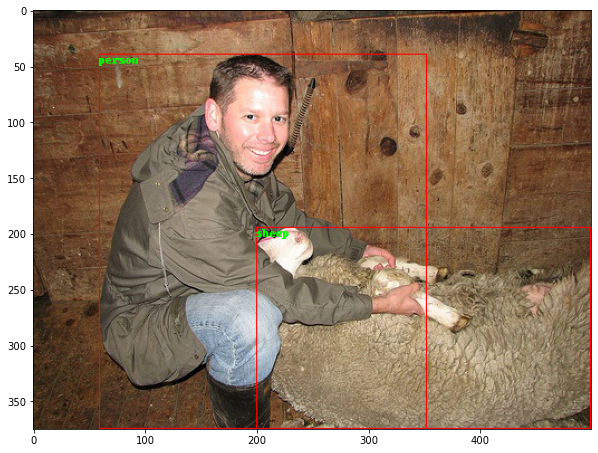

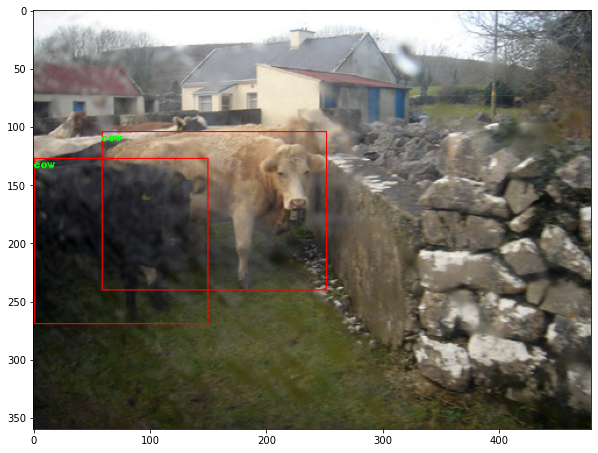

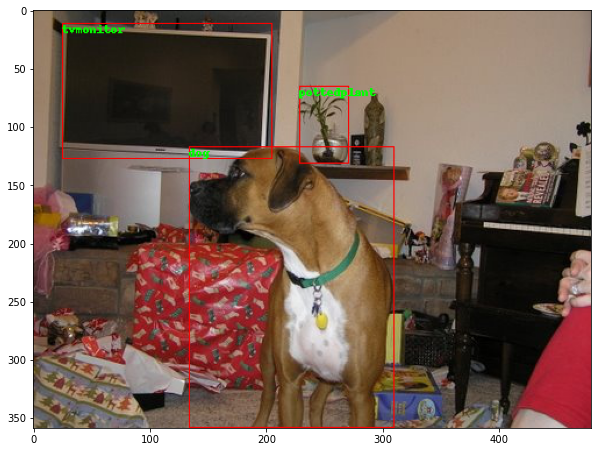

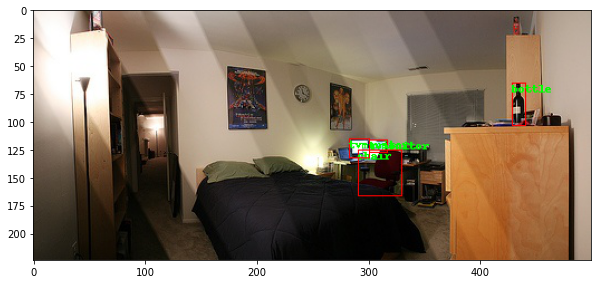

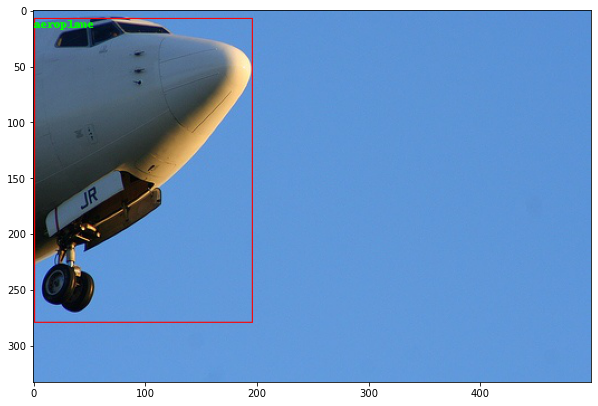

In [7]:
for i in range(5):
    idx = np.random.randint(0, len(ds_train.names)+1)
    _imgpath = os.path.join('VOCdevkit_2007/VOC2007/', 'JPEGImages', ds_train.names[idx]+'.jpg')
    img = Image.open(_imgpath).convert('RGB')
    draw = ImageDraw.Draw(img)
    for j in range(len(ds_train.box_indices[idx])):
        obj = ds_train.box_indices[idx][j]
        draw.rectangle(list(obj), outline=(255,0,0))
        draw.text(list(obj[0:2]), ds_train.classes[ds_train.label_order[idx][j]], fill=(0,255,0))
    plt.figure(figsize = (10,10))
    plt.imshow(np.array(img))

# Classification

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
train_loader = torch.utils.data.DataLoader(dataset=ds_train,
                                               batch_size=36, 
                                               shuffle=True,
                                               num_workers=10)

In [10]:
val_loader = torch.utils.data.DataLoader(dataset=ds_val,
                                               batch_size=36,
                                               shuffle=True,
                                               num_workers=10)

In [11]:
def train_classifier(train_loader, classifier, criterion, optimizer):
    classifier.train()
    loss_ = 0.0
    losses = []
    for i, (images, labels, _) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = classifier(images)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss)
    return torch.stack(losses).mean().item()

In [12]:
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    with torch.no_grad():
        y_true = np.zeros((0,21))
        y_score = np.zeros((0,21))
        for i, (images, labels, _) in enumerate(test_loader):
            images, labels = images.to(device), labels.to(device)
            logits = classifier(images)
            y_true = np.concatenate((y_true, labels.cpu().numpy()), axis=0)
            y_score = np.concatenate((y_score, logits.cpu().numpy()), axis=0)
            loss = criterion(logits, labels)
            losses.append(loss)
        aps = []
        # ignore first class which is background
        for i in range(1, y_true.shape[1]):
            ap = average_precision_score(y_true[:, i], y_score[:, i])
            if print_ind_classes:
                print('-------  Class: {:<12}     AP: {:>8.4f}  -------'.format(VOC_CLASSES[i], ap))
            aps.append(ap)
        
        mAP = np.mean(aps)
        test_loss = torch.mean(torch.stack(losses))
#         test_loss = np.mean(losses)
        print('mAP: {0:.4f}'.format(mAP))
        print('Avg loss: {}'.format(test_loss))
        
    return mAP, test_loss, aps

## Modifying the network 

The network you are given as is will allow you to reach around 0.15-0.2 mAP. To meet the benchmark for this assignment you will need to improve the network. There are a variety of different approaches you should try:

* Network architecture changes
    * Number of layers: try adding layers to make your network deeper
    * Batch normalization: adding batch norm between layers will likely give you a significant performance increase
    * Residual connections: as you increase the depth of your network, you will find that having residual connections like those in ResNet architectures will be helpful
* Optimizer: Instead of plain SGD, you may want to add a learning rate schedule, add momentum, or use one of the other optimizers you have learned about like Adam. Check the `torch.optim` package for other optimizers
* Data augmentation: You should use the `torchvision.transforms` module to try adding random resized crops and horizontal flips of the input data. Check `transforms.RandomResizedCrop` and `transforms.RandomHorizontalFlip` for this
* Epochs: Once you have found a generally good hyperparameter setting try training for more epochs
* Loss function: You might want to add weighting to the `MultiLabelSoftMarginLoss` for classes that are less well represented or experiment with a different loss function



In [13]:
classifier = torch.nn.DataParallel(Classifier()).to(device)
# You can can use this function to reload a network you have already saved previously
#classifier.load_state_dict(torch.load('voc_classifier.pth'))
print(classifier)

DataParallel(
  (module): Classifier(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(128, 152, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_bn): BatchNorm2d(152, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv4): Conv2d(152, 192, kernel_size=(3, 3), stride=(1, 1))
    (conv4_bn): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(192, 128, kernel_size=(3, 3), stride=(1, 1))
    (conv5_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_f

In [14]:
criterion = nn.MultiLabelSoftMarginLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=0.01, momentum=0.9)

In [15]:
# Training the Classifier
NUM_EPOCHS = 50
TEST_FREQUENCY = 2
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True, threshold=0.01)

for epoch in range(1, NUM_EPOCHS+1):
    print("-"*80)
    print("Starting epoch number " + str(epoch))
    train_loss = train_classifier(train_loader, classifier, criterion, optimizer)
    print("Loss for Training on Epoch " +str(epoch) + " is "+ str(train_loss))
#     scheduler.step(train_loss)
    
    if(epoch%TEST_FREQUENCY==0):
        print("*"*50)
        mAP_val, val_loss, _ = test_classifier(val_loader, classifier, criterion)
        print('Evaluating classifier')
        print("Mean Precision Score for Testing on Epoch " +str(epoch) + " is "+ str(mAP_val))
        

--------------------------------------------------------------------------------
Starting epoch number 1
Loss for Training on Epoch 1 is 0.7009066939353943
--------------------------------------------------------------------------------
Starting epoch number 2
Loss for Training on Epoch 2 is 0.6932321190834045
**************************************************
-------  Class: aeroplane        AP:   0.0506  -------
-------  Class: bicycle          AP:   0.0530  -------
-------  Class: bird             AP:   0.0602  -------
-------  Class: boat             AP:   0.0402  -------
-------  Class: bottle           AP:   0.0434  -------
-------  Class: bus              AP:   0.0386  -------
-------  Class: car              AP:   0.1430  -------
-------  Class: cat              AP:   0.0709  -------
-------  Class: chair            AP:   0.1155  -------
-------  Class: cow              AP:   0.0299  -------
-------  Class: diningtable      AP:   0.0530  -------
-------  Class: dog             

In [ ]:
# Save the clssifier network
# Suggestion: you can save checkpoints of your network during training and reload them later
torch.save(classifier.state_dict(), './voc_classifier.pth')

# Evaluate on test set



In [ ]:
ds_test = VocDataset('VOCdevkit_2007/VOC2007test/','test', test_transform)

test_loader = torch.utils.data.DataLoader(dataset=ds_test,
                                               batch_size=50, 
                                               shuffle=False,
                                               num_workers=1)

mAP_test, test_loss, test_aps = test_classifier(test_loader, classifier, criterion)

In [ ]:
output_submission_csv('my_solution.csv', test_aps)